## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Pindah ke folder yang terdapat dataset
%cd /content/drive/MyDrive/isarat

/content/drive/MyDrive/isarat


In [ ]:
print(os.listdir("/content/drive/MyDrive/isarat/Citra BISINDO"))

## Import Libraries

In [ ]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import shutil
import keras
import json
import tempfile
import requests
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import regularizers
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
import random
import matplotlib.image as mpimg
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import efficientnet

## Data Load

In [13]:
# Path untuk set pelatihan, validasi, dan pengujian
train_path = "/content/drive/MyDrive/isarat/train"
valid_path = "/content/drive/MyDrive/isarat/val"
test_path = "/content/drive/MyDrive/isarat/test"

# Path data asli
original_data_path = "/content/drive/MyDrive/isarat/Citra BISINDO"

In [14]:
# Mendapatkan daftar folder kelas
class_folders = os.listdir(original_data_path)

In [16]:
# Memindahkan data ke folder train, test, dan val
for class_folder in class_folders:
    class_folder_path = os.path.join(original_data_path, class_folder)
    files = os.listdir(class_folder_path)
    train_files, validation_test_files = train_test_split(files, test_size=0.3, random_state=42)

    for file in train_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(train_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    validation_files, test_files = train_test_split(validation_test_files, test_size=0.5, random_state=42)

    for file in test_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(test_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for file in validation_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(valid_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

In [17]:
train_dir = "/content/drive/MyDrive/isarat/train"

unique_labels =  ['T', 'V', 'X', 'S', 'Q', 'Z', 'Y', 'R', 'U', 'W', 'G', 'O', 'K', 'I', 'N', 'H', 'P', 'J', 'L', 'M', 'B', 'A', 'E', 'D', 'C', 'F']


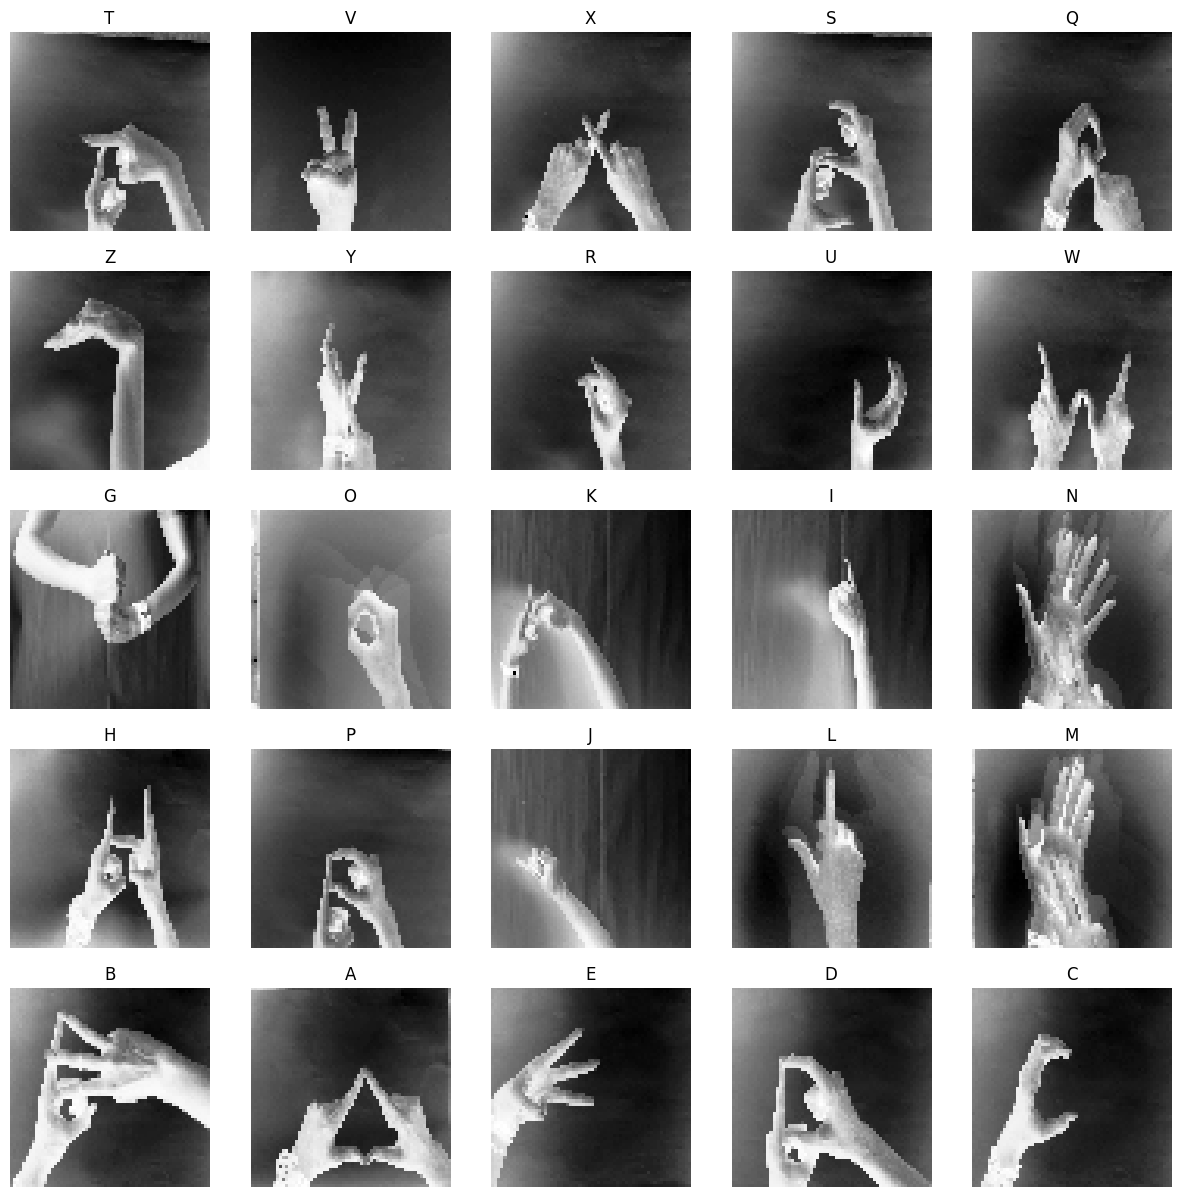

In [18]:
def load_unique():
    size_img = 64,64
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image,cmap='Greys')
    plt.title(label)
    return

image_index = 0
row = 5
col = 5
for i in range(1,(row*col+1)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

## Data Pre-Processing

In [19]:
# Preprocessing data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create data generator objects for training set
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Create data generator objects for validation set
valid_generator = datagen.flow_from_directory(
    valid_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Create data generator objects for test set
test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 1666 images belonging to 26 classes.
Found 365 images belonging to 26 classes.
Found 365 images belonging to 26 classes.


In [23]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25}

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(labels_dict[folder])

    images = np.array(images)
    images = images.astype('float32')/255.0

    labels = keras.utils.to_categorical(labels)

    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.12)

    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)

    return X_train, X_test, Y_train, Y_test

In [26]:
X_train, X_test, Y_train, Y_test = load_data()

LOADING DATA FROM : T | V | X | S | Q | Z | Y | R | U | W | G | O | K | I | N | H | P | J | L | M | B | A | E | D | C | F | 
Loaded 1466 images for training, Train data shape = (1466, 64, 64, 3)
Loaded 200 images for testing Test data shape = (200, 64, 64, 3)


In [28]:
# Extract a batch of data from the generator
images, labels = next(test_generator)

# Print the shape of the batch of images and labels
print("Shape of images batch:", images.shape)
print("Shape of labels batch:", labels.shape)

Shape of images batch: (32, 256, 256, 3)
Shape of labels batch: (32, 26)


## Model Building

In [35]:
model = Sequential()

model.add(Conv2D(16, kernel_size = [3,3], padding = 'same', activation = 'relu', input_shape = (64,64,3)))
model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = [3,3]))

model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = [3,3], padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = [3,3]))

model.add(Conv2D(128, kernel_size = [3,3], padding = 'same', activation = 'relu'))
model.add(Conv2D(256, kernel_size = [3,3], padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = [3,3]))

model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
model.add(Dense(26, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])

print("MODEL CREATED")
model.summary()

MODEL CREATED
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 21, 21, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                   

## define the early stopping callback

In [39]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=2)

## KFold

In [40]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
#kf= StratifiedKFold(n_splits=3)
kf = KFold(n_splits=3)

In [44]:
def get_score (model, x_train, x_test, y_train, y_test):
    curr_model_hist= model.fit(x_train,y_train, batch_size = 64, callbacks=[es],validation_data=(x_test,y_test),epochs=20)
    test_score = model.evaluate(x_test,y_test)
    train_score = model.evaluate(x_train,y_train)
    plotHistory(curr_model_hist)
    return train_score,test_score

# plot training history

In [45]:
def plotHistory(curr_model_hist):
    plt.plot(curr_model_hist.history['accuracy'])
    plt.plot(curr_model_hist.history['val_accuracy'])
    plt.legend(['train', 'test'], loc='lower right')
    plt.title('accuracy plot - train vs test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

    plt.plot(curr_model_hist.history['loss'])
    plt.plot(curr_model_hist.history['val_loss'])
    plt.legend(['training loss', 'validation loss'], loc = 'upper right')
    plt.title('loss plot - training vs vaidation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

# model training KFoLD

Epoch 1/20
16/16 [==============================] - 0s 27ms/step - loss: 0.5018 - accuracy: 0.9724 - val_loss: 1.0949 - val_accuracy: 0.9530
Epoch 2/20
16/16 [==============================] - 0s 17ms/step - loss: 0.4678 - accuracy: 0.9765 - val_loss: 1.1257 - val_accuracy: 0.9693
Epoch 3/20
16/16 [==============================] - 0s 17ms/step - loss: 0.4299 - accuracy: 0.9877 - val_loss: 0.9639 - val_accuracy: 0.9755
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 0.4138 - accuracy: 0.9867 - val_loss: 0.8443 - val_accuracy: 0.9734
Epoch 5/20
16/16 [==============================] - 0s 21ms/step - loss: 0.3888 - accuracy: 0.9949 - val_loss: 0.6778 - val_accuracy: 0.9898
Epoch 6/20
16/16 [==============================] - 0s 20ms/step - loss: 0.3755 - accuracy: 0.9939 - val_loss: 0.6923 - val_accuracy: 0.9816
Epoch 7/20
16/16 [==============================] - 0s 22ms/step - loss: 0.3623 - accuracy: 0.9949 - val_loss: 0.5533 - val_accuracy: 0.9877
Epoch 8/20
16

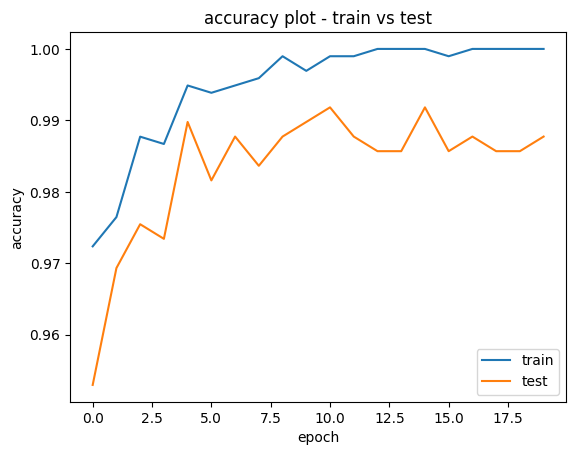

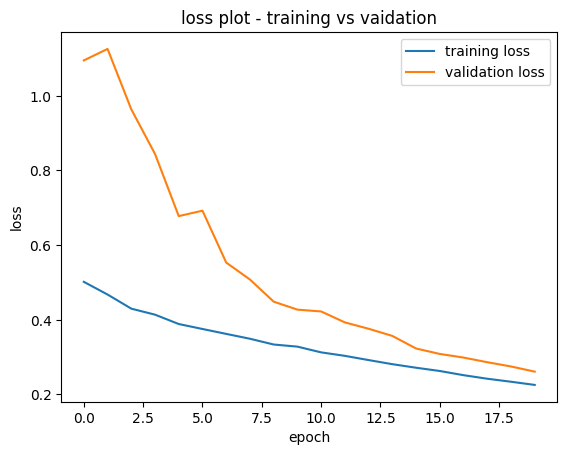

Epoch 1/20
16/16 [==============================] - 0s 25ms/step - loss: 0.2492 - accuracy: 0.9898 - val_loss: 0.2268 - val_accuracy: 0.9980
Epoch 2/20
16/16 [==============================] - 0s 17ms/step - loss: 0.2366 - accuracy: 0.9959 - val_loss: 0.9289 - val_accuracy: 0.7607
Epoch 3/20
16/16 [==============================] - 0s 19ms/step - loss: 0.2163 - accuracy: 0.9980 - val_loss: 0.2132 - val_accuracy: 1.0000
Epoch 4/20
16/16 [==============================] - 0s 19ms/step - loss: 0.2117 - accuracy: 0.9949 - val_loss: 0.2109 - val_accuracy: 0.9939
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 0.2028 - accuracy: 0.9980 - val_loss: 0.2086 - val_accuracy: 0.9939
Epoch 6/20
16/16 [==============================] - 0s 18ms/step - loss: 0.1953 - accuracy: 0.9969 - val_loss: 0.2146 - val_accuracy: 0.9939
Epoch 7/20
16/16 [==============================] - 0s 18ms/step - loss: 0.1863 - accuracy: 0.9990 - val_loss: 0.1831 - val_accuracy: 1.0000
Epoch 8/20
16

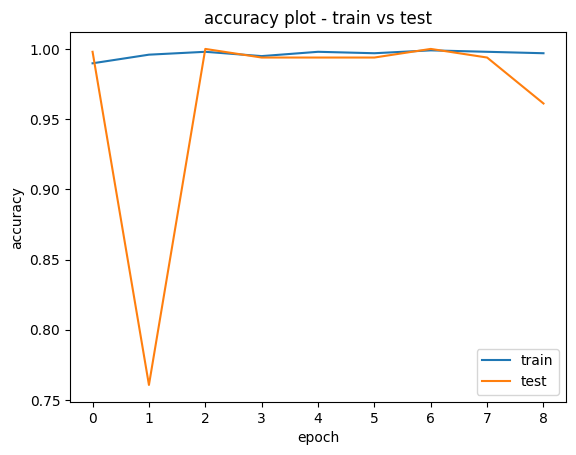

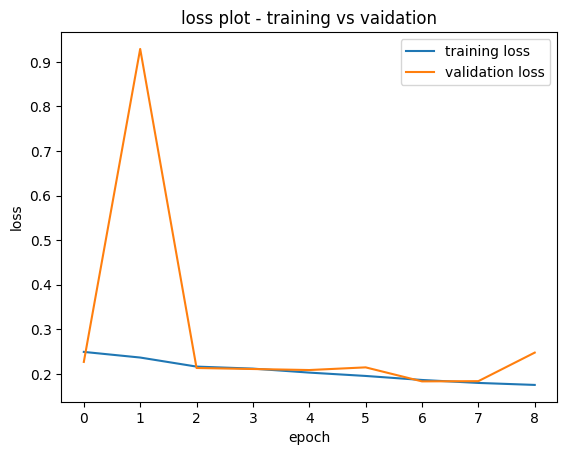

Epoch 1/20
16/16 [==============================] - 0s 27ms/step - loss: 0.1815 - accuracy: 0.9949 - val_loss: 0.1646 - val_accuracy: 0.9980
Epoch 2/20
16/16 [==============================] - 0s 23ms/step - loss: 0.1660 - accuracy: 0.9990 - val_loss: 0.1604 - val_accuracy: 0.9980
Epoch 3/20
16/16 [==============================] - 0s 22ms/step - loss: 0.1553 - accuracy: 1.0000 - val_loss: 0.1607 - val_accuracy: 0.9980
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 0.1480 - accuracy: 1.0000 - val_loss: 0.1466 - val_accuracy: 1.0000
Epoch 5/20
16/16 [==============================] - 0s 21ms/step - loss: 0.1452 - accuracy: 0.9990 - val_loss: 0.1477 - val_accuracy: 0.9959
Epoch 6/20
16/16 [==============================] - 0s 22ms/step - loss: 0.1373 - accuracy: 1.0000 - val_loss: 0.1355 - val_accuracy: 0.9980
Epoch 7/20
16/16 [==============================] - 0s 20ms/step - loss: 0.1320 - accuracy: 1.0000 - val_loss: 0.1380 - val_accuracy: 0.9980
Epoch 8/20
16

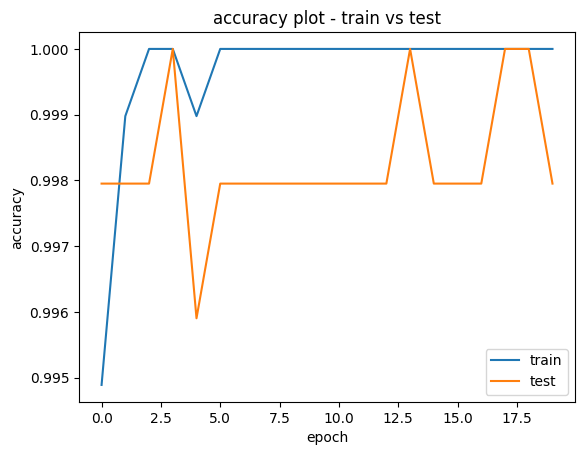

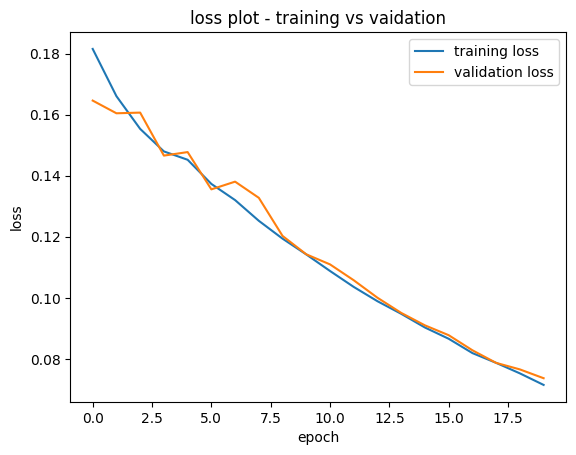

In [46]:
scores = []

for train_index, test_index in kf.split(X_train):
    x_train, x_test, y_train, y_test = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    scores.append(get_score(model,x_train,x_test,y_train,y_test))

In [47]:
scores

[([0.2208677977323532, 1.0], [0.26121389865875244, 0.987730085849762]),
 ([0.21121098101139069, 0.9815762639045715],
  [0.24766585230827332, 0.9611452221870422]),
 ([0.06805124133825302, 1.0], [0.07366175949573517, 0.9979507923126221])]

# calculating the average loss and accuracy

In [48]:
total_train_loss = 0
total_train_acc = 0
total_test_loss = 0
total_test_acc = 0
for i in range (3):
    total_train_loss = total_train_loss+scores[i][0][0]
    total_train_acc =total_train_acc+scores[i][0][1]
    total_test_loss =total_test_loss+scores[i][1][0]
    total_test_acc =total_test_acc+scores[i][1][1]
print(total_train_acc/3)
print(total_train_loss/3)
print(total_test_acc/3)
print(total_test_loss/3)

0.9938587546348572
0.16671000669399896
0.9822753667831421
0.19418050348758698


# Testing the model with test data


In [49]:
evaluate_metrics = model.evaluate(X_test, Y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

7/7 [==============================] - 0s 5ms/step - loss: 0.1362 - accuracy: 0.9750

Evaluation Accuracy =  97.50% 
Evaluation loss =  0.136193


## Evaluate the model with F1 score

In [66]:
def evaluate_F1(model, Y_test, X_test):
    from sklearn.metrics import f1_score
    y_true = [np.where(r == 1)[0][0] for r in Y_test]
    probabilities = model.predict(X_test)
    classes = np.argmax(probabilities, axis=1)
    return f1_score(y_true, classes, average=None)


In [67]:
evaluate_F1(model,Y_test,X_test)

7/7 [==============================] - 0s 4ms/step


array([1.        , 1.        , 0.94736842, 0.95238095, 1.        ,
       1.        , 1.        , 1.        , 0.93333333, 1.        ,
       1.        , 0.94736842, 0.90909091, 1.        , 0.94117647,
       0.96      , 1.        , 1.        , 1.        , 1.        ,
       0.94736842, 0.93333333, 1.        , 1.        , 0.94117647,
       1.        ])

In [68]:
model.save('MODEL A.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
